# Principal Component Analysis

## References

https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

## Import Python Libraries

In [811]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [812]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [813]:
# Source: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: fixed acidity
# X02: volatile acidity
# X03: citric acid
# X04: residual sugar
# X05: chlorides
# X06: free sulfur dioxide
# X07: total sulfur dioxide
# X08: density
# X09: pH
# X10: sulphates
# X11: alcohol
#   y: quality (score between 0 and 10)
# X12: Id

In [814]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/wine_quality.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [815]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'quality'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [816]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,y,X12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [817]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     1143 non-null   float64
 1   X02     1143 non-null   float64
 2   X03     1143 non-null   float64
 3   X04     1143 non-null   float64
 4   X05     1143 non-null   float64
 5   X06     1143 non-null   float64
 6   X07     1143 non-null   float64
 7   X08     1143 non-null   float64
 8   X09     1143 non-null   float64
 9   X10     1143 non-null   float64
 10  X11     1143 non-null   float64
 11  y       1143 non-null   int64  
 12  X12     1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [818]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,y,X12
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [819]:
# check missing values
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
y      0
X12    0
dtype: int64

## Data Cleaning and Transformation

In [820]:
# drop useless columns
drop_id = ['X12']
df1 = df1.drop(columns = drop_id, errors = 'ignore')

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [821]:
# response column
y_col = new_y_col
y_col

'y'

In [822]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11'],
      dtype='object')

In [823]:
# get unique y_labels
y_labels = np.sort(df1[y_col].unique())
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}

In [824]:
# rename y_labels
df1[y_col] = df1[y_col].replace(y_labels)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


In [825]:
# check label distribution
temp_labels = list(y_labels.values())
cond_list = []
count_list = []
for i in np.arange(len(temp_labels)):
  # condition for rows matching response label
  # print(i)
  x = temp_labels[i]
  temp_cond = list(df1[y_col] == x)
  cond_list.append(temp_cond)
  # print(cond_list)
  # get total label count
  temp_n = np.sum(cond_list[i])
  # print(temp_n)
  count_list.append(temp_n)
  
# max label count
n_max = np.max(count_list)
# index where max value occurs
i_max = np.where(count_list == n_max)[0][0]
# index where max value does not occurs
i_notmax = np.where(count_list != n_max)[0]

print(temp_labels)
print(count_list)
print(n_max)
print(i_max)
print(i_notmax)

[0, 1, 2, 3, 4, 5]
[6, 33, 483, 462, 143, 16]
483
2
[0 1 3 4 5]


In [826]:
# upsample minority labels
df_upsample_list = []
for i in i_notmax:
  # print(i)
  # get dataframe rows where label exsists
  cond = cond_list[i]
  # print(cond)
  df_temp = df1.iloc[cond,:]
  # print(df_temp.info())
  
  # determine amount to upsample 
  n_diff = n_max - count_list[i]
  # print(n_diff)
  
  # generate upsample dataframe 
  df_upsample_temp = resample(
    df_temp,
    replace = True,
    n_samples = n_diff,
    random_state = random_state
  )
  df_upsample_list.append(df_upsample_temp)

# put all dataframes in df_upsample_list into one
df_upsample_list = pd.concat(df_upsample_list, ignore_index = True)

# update df1 with upsampled dataframe
df1 = pd.concat([df1, df_upsample_list], ignore_index = True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2898 entries, 0 to 2897
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     2898 non-null   float64
 1   X02     2898 non-null   float64
 2   X03     2898 non-null   float64
 3   X04     2898 non-null   float64
 4   X05     2898 non-null   float64
 5   X06     2898 non-null   float64
 6   X07     2898 non-null   float64
 7   X08     2898 non-null   float64
 8   X09     2898 non-null   float64
 9   X10     2898 non-null   float64
 10  X11     2898 non-null   float64
 11  y       2898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 271.8 KB


In [827]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
# df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


In [828]:
# update df1
X = df1[X_cols]
y = df1[y_col]
df1 = pd.concat([X, y], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2898 entries, 0 to 2897
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     2898 non-null   float64
 1   X02     2898 non-null   float64
 2   X03     2898 non-null   float64
 3   X04     2898 non-null   float64
 4   X05     2898 non-null   float64
 5   X06     2898 non-null   float64
 6   X07     2898 non-null   float64
 7   X08     2898 non-null   float64
 8   X09     2898 non-null   float64
 9   X10     2898 non-null   float64
 10  X11     2898 non-null   float64
 11  y       2898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 271.8 KB


In [829]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,y
0,-0.532333,0.417927,-1.256778,-0.521396,-0.199107,-0.264295,-0.133128,0.584361,1.125392,-0.577416,-1.003928,2
1,-0.317554,1.076510,-1.256778,0.009633,0.251173,1.163247,0.983038,0.099957,-0.682375,0.086086,-0.683604,2
2,-0.317554,0.637455,-1.077924,-0.217951,0.128369,0.143574,0.543336,0.196838,-0.332484,-0.079790,-0.683604,2
3,1.508063,-1.118766,1.247181,-0.521396,-0.219575,0.347509,0.746276,0.681242,-0.915635,-0.466832,-0.683604,3
4,-0.532333,0.417927,-1.256778,-0.521396,-0.199107,-0.264295,-0.133128,0.584361,1.125392,-0.577416,-1.003928,2


In [830]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

## Visualize Dataset

In [831]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (15, 15)

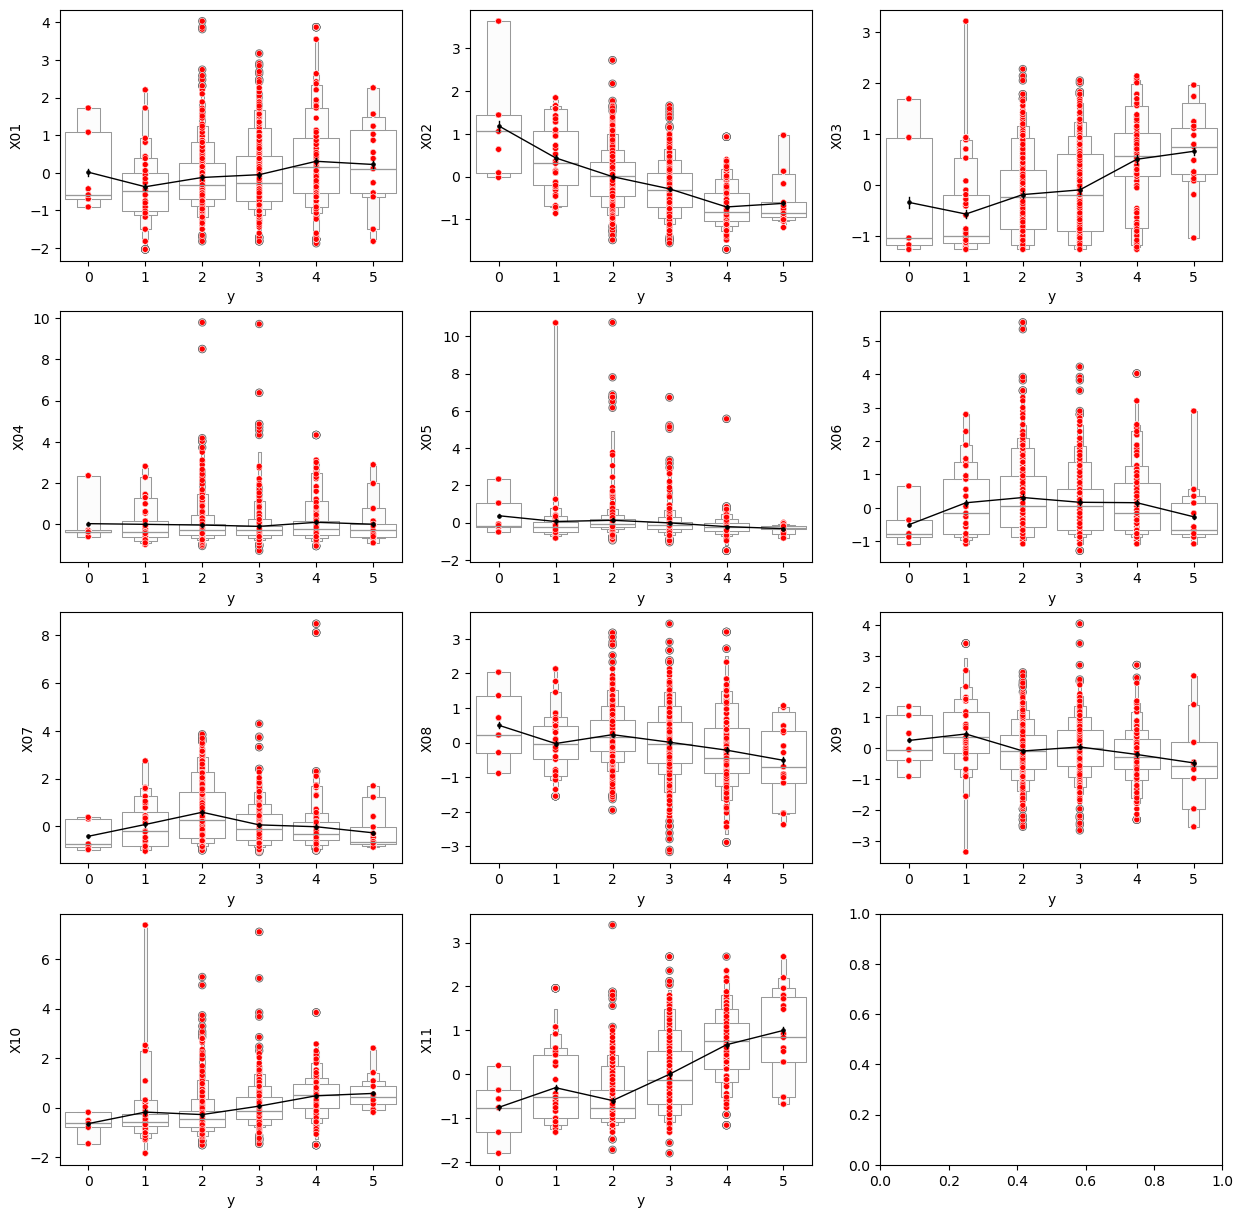

In [832]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.scatterplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Train and Test ML Model

In [891]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [903]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
  stratify = y, shuffle = True, 
  train_size = 0.9, random_state = random_state
)

In [904]:
# get principal components
pca = PCA(n_components = 2)
pca

PCA(n_components=2)

In [905]:
# fit principal component to traingin data
pca.fit(X_train, y_train)

PCA(n_components=2)

In [906]:
# pca explained variance ration
var_ratio = pca.explained_variance_ratio_
var_ratio.sum()

0.4807123722765995

In [907]:
# transform data based on principal components
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [927]:
# initialize Decision Tree model
myfit = LogisticRegression(
  fit_intercept = True,
  tol = 1E-15,
  random_state = random_state
)

In [928]:
# fit model
temp = myfit.fit(X_train, y_train)

In [929]:
# get predictions on test data
y_hat = myfit.predict(X_test)

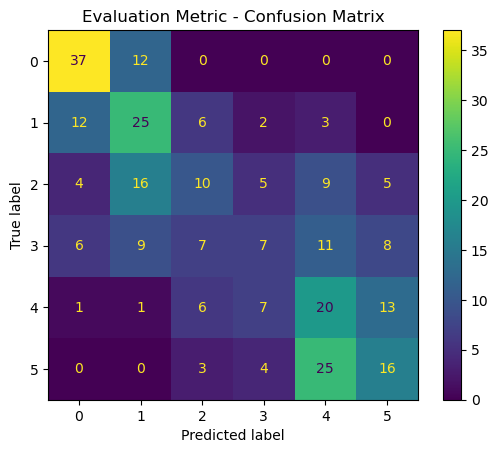

In [930]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [931]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       0.62      0.76      0.68        49
           1       0.40      0.52      0.45        48
           2       0.31      0.20      0.25        49
           3       0.28      0.15      0.19        48
           4       0.29      0.42      0.34        48
           5       0.38      0.33      0.36        48

    accuracy                           0.40       290
   macro avg       0.38      0.40      0.38       290
weighted avg       0.38      0.40      0.38       290



(-3.611915575919484, 7.214304826072956)

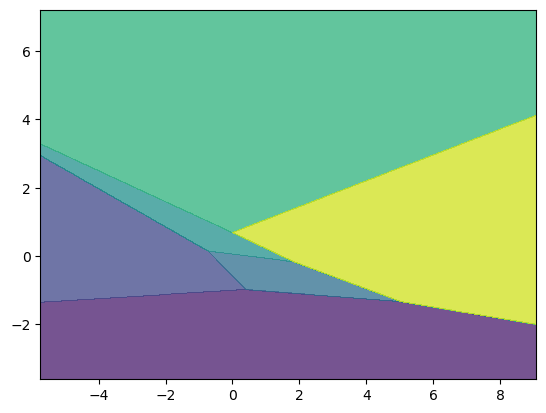

In [932]:
# user-defined function for plotting clusters
X_values, y_values = X_train, y_train
X1_min = X_values[:,0].min() - 1
X2_min = X_values[:,1].min() - 1
X2_max = X_values[:,1].max() + 1
X1_max = X_values[:,0].max() + 1
X1_values = np.arange(X1_min, X1_max, 0.01)
X2_values = np.arange(X2_min, X2_max, 0.01)

X1, X2 = np.meshgrid(X1_values, X2_values)

X_train_fill = np.array([X1.ravel(), X2.ravel()]).T
y_train_hat_fill = myfit.predict(X_train_fill).reshape(X1.shape)
y_train_hat_fill

plt.contourf(X1, X2, y_train_hat_fill, alpha = 0.75)

plt.xlim(X1_min, X1_max)
plt.ylim(X2_min, X2_max)